In [1]:
# add system environment variable
import sys
sys.path.append('/workspace/ControlNet_jh/ControlNet')
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  # Set the GPU 2 to use

import torch
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline
from customs.pipes.control_inpaint_pipe import StableDiffusionControlNetInpaintPipeline
from transformers import CLIPTextModel, CLIPTokenizer
import customs.custom_api as custom_api

from diffusers.schedulers.scheduling_euler_ancestral_discrete import EulerAncestralDiscreteScheduler


controlnet_path = "/data3/model_checkpoints/DIFFUSION_DB/ControlNet/diffusers/control_sd15_openpose"
SD_inpainting_path = '/data3/model_checkpoints/DIFFUSION_DB/Diffusion_models/diffusers/v15/mini-force-volt-step1-2000.inpainting'
embed_path = '/data3/model_checkpoints/DIFFUSION_DB/embeddings/v15'
embed_list = ['bad-hands','real-korean-style','mini-force-volt']

# load tokenizer
tokenizer = CLIPTokenizer.from_pretrained(
    controlnet_path,
    subfolder="tokenizer",
)
text_encoder = CLIPTextModel.from_pretrained(
    controlnet_path, 
    subfolder="text_encoder", 
    torch_dtype=torch.float16
)

# add tokens
custom_api.add_token(embed_path=embed_path,tokens=embed_list,tokenizer=tokenizer,text_encoder=text_encoder)

# load scheduler
scheduler = EulerAncestralDiscreteScheduler()

# load model & merge
pipe_control = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    controlnet_path,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    scheduler = scheduler,
    torch_dtype=torch.float16).to('cuda')
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(SD_inpainting_path,torch_dtype=torch.float16).to('cuda')

pipe_control.unet = pipe_inpaint.unet
pipe_control.unet.in_channels = 4

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


bad-hands added to CLIP tokenizer
real-korean-style added to CLIP tokenizer
mini-force-volt added to CLIP tokenizer


/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


100%|██████████| 25/25 [00:02<00:00,  9.37it/s]


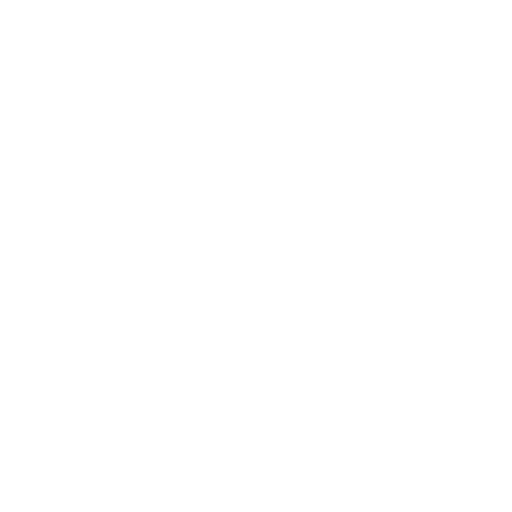

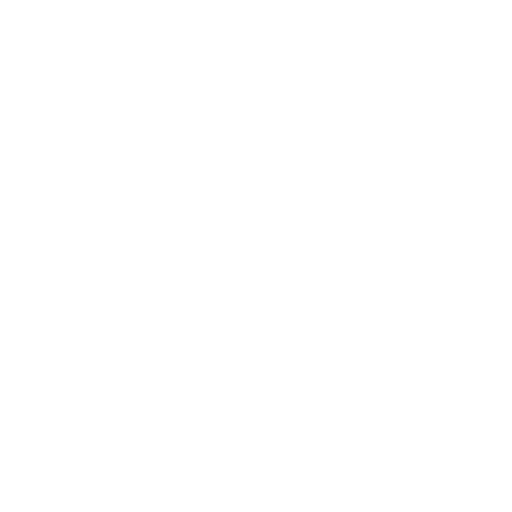

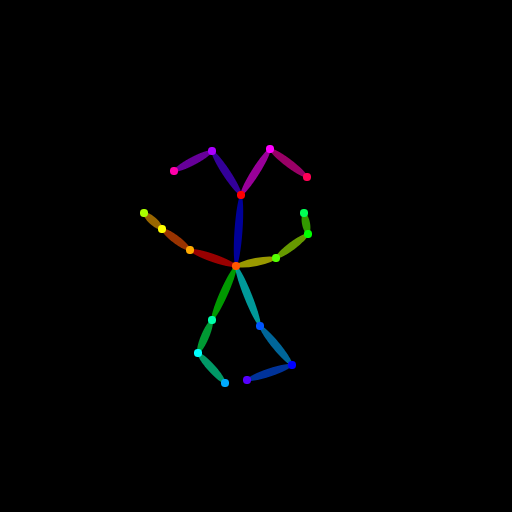

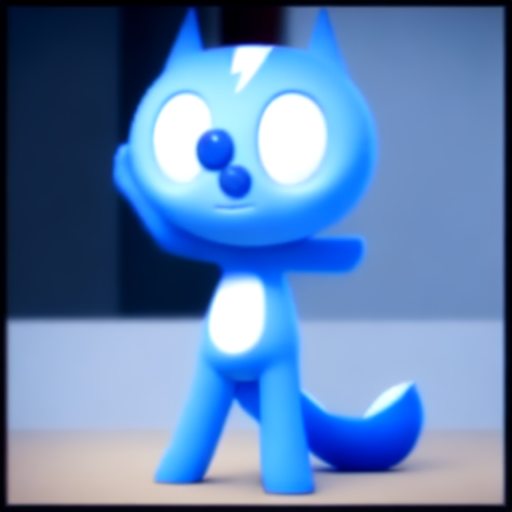

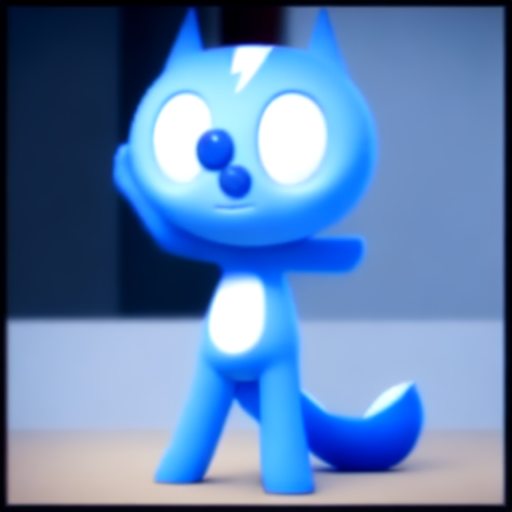

In [10]:
from ControlNet.annotator.openpose import OpenposeDetector
from ControlNet.annotator.util import HWC3
import numpy as np

condition_path = '/workspace/ControlNet_jh/test_images/pose_yw_short.png' # None or str

# load image & mask
image = Image.open("/workspace/ControlNet_jh/test_images/pose_yw_mask.png")
mask = Image.open("/workspace/ControlNet_jh/test_images/pose_yw_mask.png")   # 지우는 부분: [255,255,255] 아닌부분: [0,0,0]

# image preprocess
image = custom_api.resize_padding(image)
image = np.asanyarray(image)
image = HWC3(image)
mask = custom_api.resize_padding(mask)

# get condition
if not condition_path:
    apply_openpose = OpenposeDetector()
    detected_map, _ = apply_openpose(image)
else:
    detected_map = Image.open(condition_path)
    detected_map = custom_api.resize_padding(detected_map)
    detected_map = np.array(detected_map)


# inputs to PIL Image
detected_map = Image.fromarray(detected_map)
image = Image.fromarray(image)

# seed
custom_api.seed_everything(seed=689174160)

# run inference
out_image = pipe_control(
    prompt="mini-force-volt toy", 
    negative_prompt='',
    controlnet_hint=detected_map, 
    image=image,
    mask_image=mask,
    num_inference_steps=25,
    guidance_scale=7,
    nsfw_filter = False).images[0]


image.show()
mask.show()
detected_map.show()
out_image.show()

# merge
image = np.array(image)
out_image = np.array(out_image)
mask = np.array(mask)
out_image[np.where(np.array(mask)==0)] = image[np.where(np.array(mask)==0)]
Image.fromarray(out_image)